# Klasifikasi Berita dengan LDA (Latent Dirichlet Allocation)

**Tujuan**: Mengklasifikasikan berita berdasarkan kategori menggunakan fitur topik yang diekstrak dari LDA.

**Alur Kerja**:
1. **Setup & Load Data**: Import library dan baca dataset berita yang sudah dipreprocessing
2. **Preprocessing**: Gabungkan kategori serupa dan konversi hasil preprocessing ke format token
3. **LDA & Topic Modeling**: Cari jumlah topik optimal dan ekstrak fitur distribusi topik
4. **Klasifikasi**: Latih model SVM untuk klasifikasi kategori berita
5. **Visualisasi**: Tampilkan hasil dalam bentuk scatter plot 2D menggunakan UMAP

**Dataset**: `hasil_preprocessing_berita.csv` dengan kolom:
- `isi`: teks berita asli
- `hasil_preprocessing`: token yang sudah dibersihkan
- `kategori`: label kategori berita


## FASE 1: Setup dan Pemuatan Data

**Apa yang dilakukan**:
- Import semua library yang diperlukan (pandas, gensim, sklearn, matplotlib, umap)
- Baca dataset dari file CSV yang sudah berisi hasil preprocessing

**Mengapa penting**:
- Library gensim untuk LDA dan topic modeling
- Library sklearn untuk klasifikasi dan evaluasi
- Dataset sudah dipreprocessing sehingga menghemat waktu komputasi


In [1]:
## FASE 1: SETUP DAN PEMUATAN DATA

# Import library dasar
import pandas as pd
import numpy as np
import re
import time

# Import untuk Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from ast import literal_eval # Untuk mengubah string '[...]' menjadi list

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Klasifikasi & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import umap.umap_ as umap

print("Semua library berhasil diimpor.")

# --- Memuat Dataset ---
# Kini membaca file hasil preprocessing yang berisi kolom: isi, hasil_preprocessing, kategori
try:
    df = pd.read_csv('hasil_preprocessing_berita.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh kolom inti:")
    print(df[['isi', 'hasil_preprocessing', 'kategori']].head())
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()

Semua library berhasil diimpor.

Dataset berhasil dimuat. Jumlah data: 1600 baris.
Contoh kolom inti:
                                                 isi  \
0  Wakil Ketua DPRSufmi Dasco Ahmadmengungkap isi...   
1  Jaksa Penuntut Umum (JPU) menuntut majelis hak...   
2  Menteri KebudayaanFadli Zonmembeberkan rencana...   
3  Sebanyak tiga purnawirawan TNI/Polri bergabung...   
4  AktorAmmar Zonikembali terlibat dalam kasus pe...   

                                 hasil_preprocessing  kategori  
0  ['wakil', 'ketua', 'dprsufmi', 'dasco', 'ahmad...  nasional  
1  ['jaksa', 'tuntut', 'jpu', 'tuntut', 'majelis'...  nasional  
2  ['menteri', 'kebudayaanfadli', 'zonmembeberkan...  nasional  
3  ['purnawirawan', 'tnipolri', 'gabung', 'dalamk...  nasional  
4  ['aktorammar', 'zonikembali', 'libat', 'edar',...  nasional  


## FASE 2: Preprocessing dan Penggabungan Kategori

**Apa yang dilakukan**:
- **Penggabungan kategori**: Menggabungkan subkategori regional (Jatim, Jatim Barat, dll) menjadi satu kategori "Berita Regional Jatim"
- **Konversi token**: Mengubah kolom `hasil_preprocessing` menjadi format list token yang bisa diproses gensim

**Mengapa penting**:
- Mengurangi fragmentasi kategori (dari banyak subkategori menjadi kategori yang lebih umum)
- Memastikan format token kompatibel dengan gensim (list of strings)
- Meningkatkan kualitas klasifikasi dengan kategori yang lebih seimbang


In [2]:
## FASE 2: PRA-PEMROSESAN TEKS DAN PENGGABUNGAN KATEGORI

# --- A. Penggabungan Kategori (Opsional, tapi Sangat Direkomendasikan) ---
# Berdasarkan analisis kita, banyak kategori regional yang tumpang tindih.
# Menggabungkannya akan sangat membantu model.
print("\n--- Memulai Penggabungan Kategori ---")
mapping_kategori = {
    'Jatim': 'Berita Regional Jatim', 'Jatim Barat': 'Berita Regional Jatim',
    'Jatim Madura': 'Berita Regional Jatim', 'Jatim Metro': 'Berita Regional Jatim',
    'Jatim Selatan': 'Berita Regional Jatim', 'Jatim Tengah': 'Berita Regional Jatim',
    'Jatim Timur': 'Berita Regional Jatim', 'Jatim Utara': 'Berita Regional Jatim'
}
df['kategori'] = df['kategori'].replace(mapping_kategori)
print(f"Jumlah kategori setelah digabungkan: {df['kategori'].nunique()}")


# --- B. Pra-pemrosesan Teks ---
print("\n--- Memulai Pemanfaatan Hasil Preprocessing dari CSV ---")

# Kolom 'hasil_preprocessing' diharapkan berisi token yang sudah diproses.
# Format yang didukung:
# - String token yang dipisah spasi ("kata1 kata2 kata3") -> akan di-split
# - Representasi list ("['kata1', 'kata2']") -> akan di-eval aman ke list

def ensure_tokens(value):
    if isinstance(value, list):
        return value
    if isinstance(value, str):
        text = value.strip()
        # Jika tampak seperti list Python
        if text.startswith('[') and text.endswith(']'):
            try:
                lst = literal_eval(text)
                return [str(tok) for tok in lst]
            except Exception:
                pass
        # Fallback: anggap string token dipisah spasi
        return [tok for tok in text.split() if tok]
    # Fallback untuk nilai non-string/non-list
    return []

# Buat kolom tokens langsung dari hasil_preprocessing
df['tokens'] = df['hasil_preprocessing'].apply(ensure_tokens)

print("Pemanfaatan hasil preprocessing selesai.")
print("Contoh hasil tokens:")
print(df[['kategori', 'tokens']].head())


--- Memulai Penggabungan Kategori ---
Jumlah kategori setelah digabungkan: 8

--- Memulai Pemanfaatan Hasil Preprocessing dari CSV ---
Pemanfaatan hasil preprocessing selesai.
Contoh hasil tokens:
   kategori                                             tokens
0  nasional  [wakil, ketua, dprsufmi, dasco, ahmadmengungka...
1  nasional  [jaksa, tuntut, jpu, tuntut, majelis, hakim, a...
2  nasional  [menteri, kebudayaanfadli, zonmembeberkan, ren...
3  nasional  [purnawirawan, tnipolri, gabung, dalamkomite, ...
4  nasional  [aktorammar, zonikembali, libat, edar, barang,...


## FASE 3: Ekstraksi Fitur LDA dan Pencarian Topik Optimal

**Apa yang dilakukan**:
- **Filter kamus**: Buang kata yang terlalu jarang (<15 dokumen) atau terlalu sering (>50% dokumen)
- **Estimasi HDP**: Gunakan Hierarchical Dirichlet Process untuk perkiraan awal jumlah topik
- **Grid search koherensi**: Coba berbagai jumlah topik dan pilih yang memiliki koherensi tertinggi
- **Ekstraksi fitur**: Konversi setiap dokumen menjadi vektor distribusi probabilitas topik

**Mengapa penting**:
- Filter kamus meningkatkan kualitas topik dengan menghilangkan noise
- HDP memberikan estimasi awal yang lebih akurat daripada menebak jumlah topik
- Koherensi mengukur seberapa "masuk akal" topik yang dihasilkan
- Fitur distribusi topik menjadi input untuk klasifikasi (bukan teks mentah)



Kamus dibuat dan difilter. Jumlah kata unik: 2249

--- Menjalankan HDP untuk estimasi jumlah topik... ---
✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 5 hingga 40 topik... ---
Selesai menghitung untuk 5 topik...
Selesai menghitung untuk 10 topik...
Selesai menghitung untuk 15 topik...
Selesai menghitung untuk 20 topik...
Selesai menghitung untuk 25 topik...
Selesai menghitung untuk 30 topik...
Selesai menghitung untuk 35 topik...

Total waktu pencarian koherensi: 4.65 menit


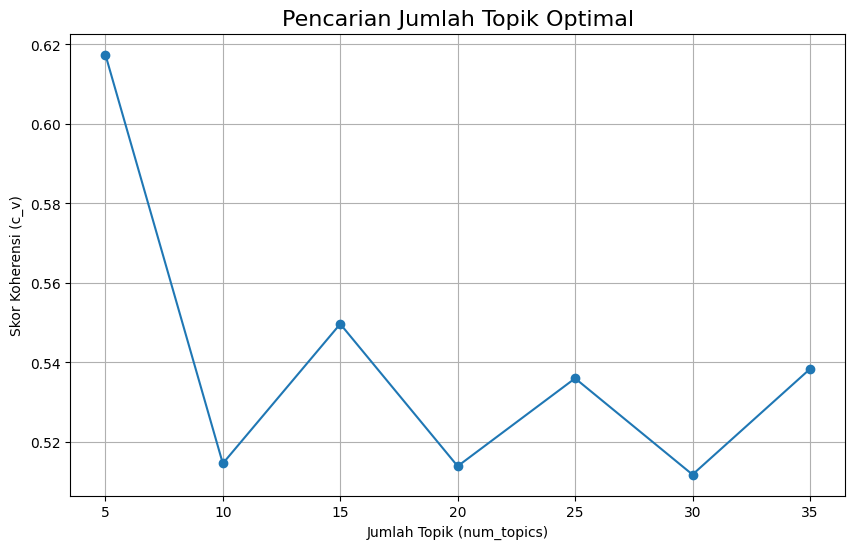


✅ Jumlah topik optimal yang ditemukan: 5

--- Melatih model LDA final dengan topik optimal... ---
Ekstraksi fitur LDA selesai.
Bentuk matriks fitur (X): (1600, 5)


In [3]:
## FASE 3: EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

# Siapkan data untuk Gensim
documents = df['tokens'].tolist()
dictionary = Dictionary(documents)

# --- A. Filter Kamus (Sesuai Referensi & Praktik Terbaik) ---
# Membuang kata yang terlalu jarang atau terlalu sering muncul.
# Ini meningkatkan kualitas topik secara signifikan.
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f"\nKamus dibuat dan difilter. Jumlah kata unik: {len(dictionary)}")


# --- B. Estimasi Jumlah Topik dengan HDP (Langkah Cerdas) ---
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


# --- C. Mencari Jumlah Topik Terbaik dengan Plot Koherensi ---
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    start_time = time.time()
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=10, workers=3)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Selesai menghitung untuk {num_topics} topik...")
    total_time = time.time() - start_time
    print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
    return coherence_values

# Atur rentang pencarian di sekitar hasil HDP
search_start = max(2, estimated_num_topics - 15)
search_limit = estimated_num_topics + 20
search_step = 5

print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                    start=search_start, limit=search_limit, step=search_step)

# Tampilkan grafik
x = range(search_start, search_limit, search_step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Pencarian Jumlah Topik Optimal", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Pilih jumlah topik terbaik (yang memiliki skor koherensi tertinggi)
optimal_num_topics = x[np.argmax(coherence_values)]
print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")


# --- D. Latih Model LDA Final & Ekstrak Fitur ---
print("\n--- Melatih model LDA final dengan topik optimal... ---")
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                         random_state=42, passes=15)

# Ekstrak fitur (distribusi topik) untuk setiap dokumen
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * optimal_num_topics
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

X = get_lda_features(lda_model, corpus)
y = df['kategori'].values

print("Ekstraksi fitur LDA selesai.")
print(f"Bentuk matriks fitur (X): {X.shape}")

## FASE 4: Pelatihan dan Evaluasi Model Klasifikasi

**Apa yang dilakukan**:
- **Split data**: Bagi dataset menjadi 80% training dan 20% testing dengan stratifikasi
- **Training SVM**: Latih model Support Vector Machine dengan kernel linear
- **Evaluasi**: Hitung akurasi dan laporan klasifikasi (precision, recall, F1-score per kategori)

**Mengapa penting**:
- Stratifikasi memastikan proporsi kategori sama di training dan testing
- SVM kernel linear cocok untuk fitur high-dimensional seperti distribusi topik
- Evaluasi memberikan insight tentang performa model per kategori
- Akurasi 55% menunjukkan model bisa membedakan beberapa kategori dengan baik


In [4]:
## FASE 4: PELATIHAN DAN EVALUASI MODEL KLASIFIKASI

# --- A. Bagi Data menjadi Latih dan Uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData dibagi. Jumlah data latih: {len(X_train)}, Jumlah data uji: {len(X_test)}")


# --- B. Latih Model Klasifikasi (SVM) ---
# Kita gunakan SVM sesuai hasil eksperimen dan referensi.
classifier = SVC(kernel='linear', random_state=42, probability=True)

print("\n--- Memulai pelatihan model SVM... ---")
classifier.fit(X_train, y_train)
print("Pelatihan selesai.")


# --- C. Evaluasi Kinerja Model ---
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- HASIL EVALUASI AKHIR ---")
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(y_test, y_pred))


Data dibagi. Jumlah data latih: 1280, Jumlah data uji: 320

--- Memulai pelatihan model SVM... ---
Pelatihan selesai.

--- HASIL EVALUASI AKHIR ---
Akurasi Model: 55.00%

Laporan Klasifikasi (Classification Report):
               precision    recall  f1-score   support

      ekonomi       0.32      0.15      0.20        40
   gaya-hidup       0.71      0.60      0.65        40
      hiburan       0.50      0.20      0.29        40
internasional       0.72      0.72      0.72        40
     nasional       0.49      0.90      0.63        40
     olahraga       0.97      0.93      0.95        40
     otomotif       0.33      0.65      0.43        40
    teknologi       0.53      0.25      0.34        40

     accuracy                           0.55       320
    macro avg       0.57      0.55      0.53       320
 weighted avg       0.57      0.55      0.53       320



## FASE 5: Visualisasi dengan UMAP

**Apa yang dilakukan**:
- **UMAP**: Turunkan dimensi fitur topik dari 5D ke 2D untuk visualisasi
- **Scatter plot**: Tampilkan sebaran data training dan testing dalam 2D
- **Color coding**: Setiap kategori diberi warna berbeda untuk melihat pemisahan

**Mengapa penting**:
- UMAP mempertahankan struktur lokal data sehingga klaster kategori terlihat jelas
- Visualisasi membantu memahami seberapa baik fitur topik memisahkan kategori
- Perbandingan train vs test menunjukkan konsistensi model
- Jika kategori membentuk klaster terpisah, berarti fitur topik efektif untuk klasifikasi



--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\User\AppData\Local\Temp\ipykernel_8892\4126789932.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:1112: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


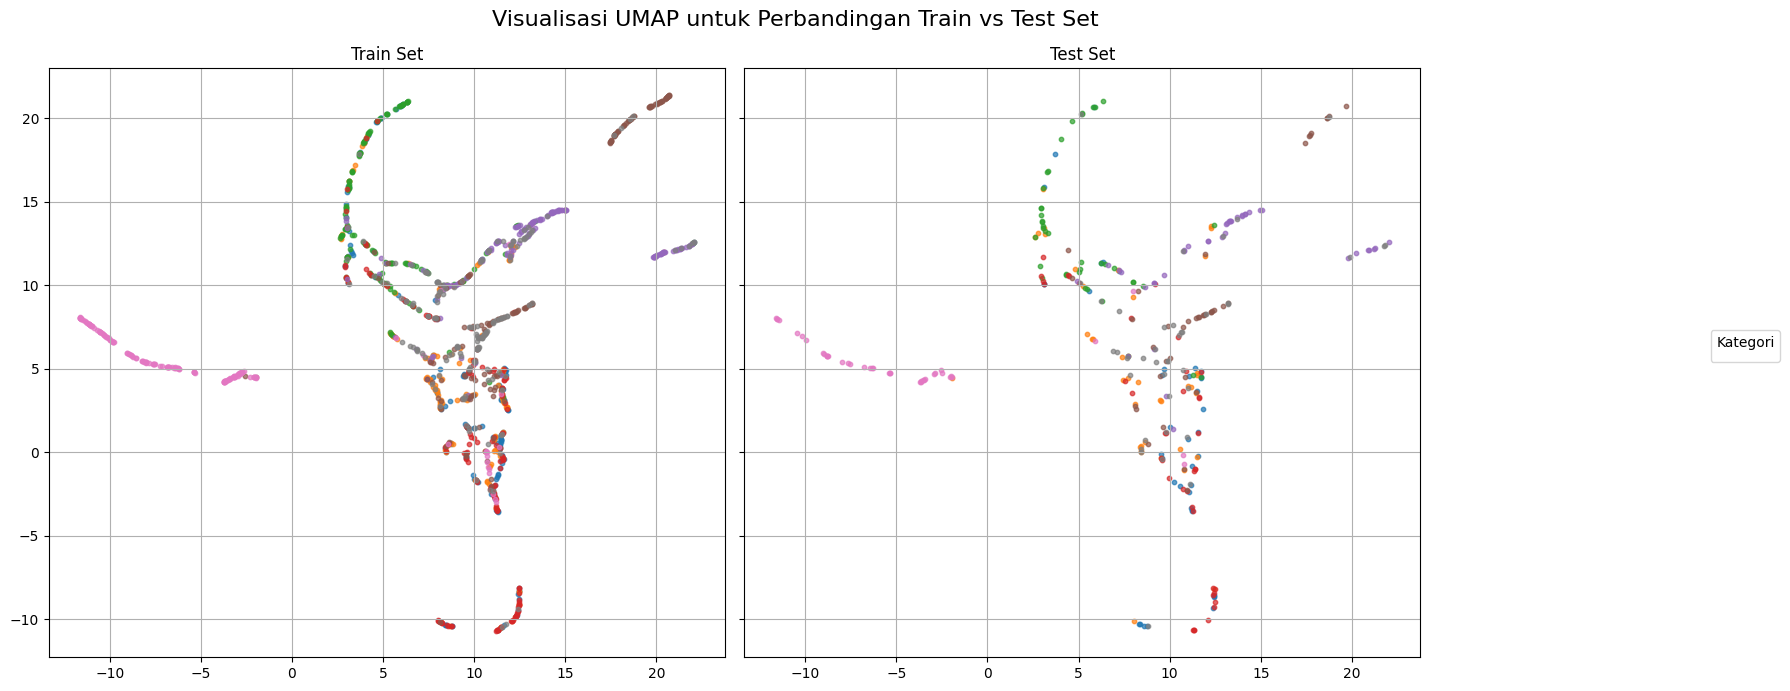


--- Selesai ---


In [5]:
## FASE 5: ANALISIS LANJUTAN DAN VISUALISASI (UMAP)

print("\n--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---")

# --- A. Siapkan Data untuk Visualisasi ---
labels = list(pd.Series(y_train).unique())
label_map = {label: i for i, label in enumerate(labels)}
y_train_numeric = pd.Series(y_train).map(label_map).values
y_test_numeric = pd.Series(y_test).map(label_map).values

# Gabungkan, skalakan, dan terapkan UMAP
X_combined = np.concatenate((X_train, X_test), axis=0)
X_scaled = StandardScaler().fit_transform(X_combined)
reducer = umap.UMAP(n_components=2, random_state=42)
X_2d_combined = reducer.fit_transform(X_scaled)
x2d_train = X_2d_combined[:len(X_train)]
x2d_test = X_2d_combined[len(X_train):]

# --- B. Fungsi untuk Menggambar Plot ---
def plot_topic_clusters(ax, x2d, y_numeric, labels, title):
    ax.set_title(title)
    colors = cm.get_cmap("Spectral", len(labels))
    for i, label_name in enumerate(labels):
        ax.scatter(x2d[y_numeric == i, 0], x2d[y_numeric == i, 1],
                   label=label_name, alpha=0.7, s=10)
    ax.grid(True)
    return ax

# --- C. Buat dan Tampilkan Dua Subplot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
plot_topic_clusters(axes[0], x2d_train, y_train_numeric, labels, "Train Set")
plot_topic_clusters(axes[1], x2d_test, y_test_numeric, labels, "Test Set")
fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

# Tambahkan legenda di luar plot
handles, current_labels = axes[0].get_legend_handles_labels()
# Gunakan `num` untuk memastikan semua handle dibuat jika kategori banyak
handles, _ = axes[0].collections[0].legend_elements(num=len(labels))
fig.legend(handles, labels, title="Kategori", loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Selesai ---")